# 3 Things you need to know before listing or booking on Airbnb in Seattle (Part 3)

## (Please note: This notebook is Part 3 of this project. Please refer to `"Seattle Airbnb Data Analysis-Part1&2"` notebook for more content)

## Part 3. What do visitors care most about their stays?
In this notebook, we will take a deep dive into the visitor reviews of their stay at Seattle Airbnbs by conducting a sentiment analysis, and try to answer the questions about how the visitors feel about their host and overall experience during their stay.

### 1. Data Exploration

In [2]:
# Import libiaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#! pip install langdetect
from langdetect import detect

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

#!pip install wordcloud==1.7.0
from wordcloud import WordCloud
import collections

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

from sklearn.model_selection import train_test_split 

#!pip list --outdated 
#!pip install --upgrade tensorflow
import tensorflow as tf

#!pip install --upgrade keras v 2.0.9-> 2.3.1
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### 1.1 Load  `reviews` data set

In [6]:
# Read in the reviews data set
df_reviews = pd.read_csv('./reviews.csv')

pd.set_option('display.max_colwidth', -1) # display full content in the cell

df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to everything!
1,7202016,39087409,2015-07-20,32440555,Frank,"Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW. Thanks for a great stay."
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighborhood. This is the kind of apartment I wish I had!\r\n\r\nDidn't really get to meet Kelly until I was on my out, but she was always readily available by phone. \r\n\r\nI believe the only ""issue"" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday"
3,7202016,40813543,2015-08-02,33671805,George,"Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the Metropolitan (probably the coolest grocer you'll ever find). Easy to find and Kelly was warm, welcoming, and really interesting to talk to."
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating in a great neighborhood. She has some great coffee and while I wasn't around much during my stay the time I spent interacting with her was very pleasant. \r\n\r\nThe apartment is in a great location and very close to the Seattle Center. The neighborhood itself has a lot of good food as well!


#### 1.2 Explore the reviews data set

In [7]:
# Find number of rows and columns in the dataset
rows = df_reviews.shape[0]
cols = df_reviews.shape[1]
print("There are {} rows and {} columns in the reviews dataset".format(rows, cols))

There are 84849 rows and 6 columns in the reviews dataset


In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


### 2. Data cleaning
#### 2.1 Remove null values

In [9]:
# Check missing values 
df_reviews.isnull().sum()

listing_id       0 
id               0 
date             0 
reviewer_id      0 
reviewer_name    0 
comments         18
dtype: int64

In [10]:
# Remove missing values in the dataset
df_reviews = df_reviews[df_reviews['comments'].notnull()]

In [11]:
df_reviews.shape 

(84831, 6)

#### 2.2 Convert data types

In [12]:
# Convert ids to string and date to datetime 
df_reviews['listing_id'] = df_reviews['listing_id'].astype(str)
df_reviews['id'] = df_reviews['id'].astype(str)
df_reviews['reviewer_id'] = df_reviews['reviewer_id'].astype(str)
df_reviews['date'] = pd.to_datetime(df_reviews['date']) 

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84831 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84831 non-null object
id               84831 non-null object
date             84831 non-null datetime64[ns]
reviewer_id      84831 non-null object
reviewer_name    84831 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 4.5+ MB


#### 2.3 Check comment language

In [13]:
# Write a function that detects different languages in the review
def language_detection(text):
    """
    If there's a text, detect which language it uses.
    Input - text: the text to be detected
    Output - language of the text (None if no text found)
    """
    
    try:
        return detect(text)
    except:
        return None

In [14]:
# Apply the language detection function to the comments column
df_reviews['language'] = df_reviews['comments'].apply(language_detection) # ~ 9min

In [15]:
# List all detected languages
df_reviews['language'].value_counts().head(10)

en       83776
fr       241  
de       212  
zh-cn    160  
es       83   
ko       52   
ro       41   
nl       39   
ja       29   
pt       26   
Name: language, dtype: int64

In [16]:
# Create a dataframe with only English reviews
df_reviews_en = df_reviews[df_reviews['language'] == 'en']
df_reviews_en.shape 

(83776, 7)

#### 2.4 Remove duplicate comments

In [17]:
# Check duplicate comments
duplicate_comments = df_reviews_en[df_reviews_en['comments'].duplicated()]
duplicate_comments

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
472,1205666,50156180,2015-10-09,34925128,Aaron_aaron,Nice house!,en
2153,6228959,35056396,2015-06-14,32283115,Becky,The host canceled this reservation the day before arrival. This is an automated posting.,en
2338,6492880,41432090,2015-08-07,3906467,Karena,The host canceled this reservation 13 days before arrival. This is an automated posting.,en
2360,4316910,51684638,2015-10-22,45864765,Maria,The host canceled this reservation the day before arrival. This is an automated posting.,en
3244,656909,3340198,2013-01-13,4393537,Bibiana,"Lisa is such a wonderful lady to stay with. I feel so lucky to have came across her house while browsing airbnb and it was the best decision ever. Since it was our first time in Seattle, she would give us some directions around her place. Her pets are very cute and mostly well-behaved. She is very kind and helpful, there is never once that she is too busy to help us whenever we needed it. Thanks Lisa! :)",en
3985,456040,6964105,2013-09-01,5117353,Bob & Evelyn,The reservation was canceled 7 days before arrival. This is an automated posting.,en
3988,456040,7121112,2013-09-07,8167840,Mallory,Tell others in the Airbnb community about your stay.,en
5050,1100714,25950548,2015-01-30,10103404,Ann,The reservation was canceled 14 days before arrival. This is an automated posting.,en
5060,1100714,27635705,2015-03-08,112877,Shandell,The reservation was canceled 6 days before arrival. This is an automated posting.,en
5080,1100714,32043655,2015-05-12,1787,Kimberly,The host canceled this reservation the day before arrival. This is an automated posting.,en


There are multiple reviews that are just automated posting, which are not quite meaningful for sentiment analysis. Let's remove them.

In [18]:
automatic_reviews = df_reviews_en[df_reviews_en['comments'].str\
                                  .contains('This is an automated posting')]
automatic_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
83,7735100,57419048,2015-12-25,13019539,Tibor,The host canceled this reservation 21 days before arrival. This is an automated posting.,en
525,4681885,36497374,2015-06-28,32856761,Zach,The host canceled this reservation the day before arrival. This is an automated posting.,en
575,2420536,21648649,2014-10-20,12714608,New,The reservation was canceled 132 days before arrival. This is an automated posting.,en
737,1122236,17034635,2014-08-05,3538520,Ran,The reservation was canceled 37 days before arrival. This is an automated posting.,en
761,1122236,40070019,2015-07-28,29398794,Matthew,The host canceled this reservation 5 days before arrival. This is an automated posting.,en


In [19]:
automatic_reviews.shape 

(796, 7)

In [20]:
# Remove duplicate automatic comments
df_reviews_en_new = df_reviews_en[~ df_reviews_en['comments']\
                                  .isin(automatic_reviews['comments'])]
df_reviews_en_new.shape 

(82980, 7)

In [21]:
# Check other duplicate comments
duplicates_more = df_reviews_en_new[df_reviews_en_new['comments'].duplicated()]
duplicates_more.sample(20)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
52756,5020861,27368379,2015-03-02,28068522,Jake,Great,en
80238,365550,25176667,2015-01-08,148408,Adam,"Though I was only passing through Seattle, I really enjoyed staying at Jaq and Dirk's artist's studio. Affordable, clean, and comfortable. Great location in Chinatown, close to both Amtrak and the Link light rail. I didn't meet Dirk or Jaq, but Jaq was very communicative and the many helpful notes around the space made navigating the space easy. Would definitely stay again!",en
34268,1950446,26011488,2015-02-01,25855179,Clay,Great place!,en
46123,557126,6014037,2013-07-26,7534560,Olakunle,Tell others in the Airbnb community about your stay.,en
54383,3940265,20719984,2014-10-04,1355275,Paola,"Great location, excellent room/house, very nice people and cats.",en
22161,6512378,55497244,2015-12-01,39464788,Cameron,Great!,en
29527,1750681,18201196,2014-08-23,16932328,Clifford,"beth's place is very clean, very homely! it is super convenient to get around seattle from where she is. she is extremely engaging to have a conversation with & i would love to stay with her the next time i go to seattle!",en
47947,132160,7191745,2013-09-10,6704584,Mary,Tell others in the Airbnb community about your stay.,en
74686,2032805,24311383,2014-12-25,24613026,鹏,"The hosts, Abil and Mellissa, are very kind and warm heart! As we are first time come to Seattle, both of them gave me precious advices. The rooms are great, nice decorated and clean. And it's quiet as well. Very morning we ate breakfirst which cooked by Mellissa, delicious and sufficient. By the way, Abil's beers are owesome!! I miss it too much! At last, we would like to give our sinere appreciation to both Abil and Mellissa. The experience stayed in your house was wonderful, thank you and best wishes to you!",en
80287,365550,33777418,2015-06-01,23218946,Neil,"Friendly hosts, great price, and excellent location. Fantastic position next to King Street Station gave direct access to Pioneer Sq and Downtown, with Capital Hill just a brisk 20 minute walk away. Room was functional, and both room and common parts were always clean and tidy. Very professionally organized, with useful handbook, and very quick response to emails before and during my stay. Enjoyed bumping into artists working in the space, and appreciated being able to leave my luggage at the development at the end of my stay. Would certainly recommend!",en


Apparently there's another automatic review which doesn't contribute to sentiment analysis. Remove these reviews too.

In [22]:
automatic_reviews2 = df_reviews_en_new[df_reviews_en['comments'].str\
                        .contains('Tell others in the Airbnb community about your stay')]
automatic_reviews2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,listing_id,id,date,reviewer_id,reviewer_name,comments,language
2983,741699,7194204,2013-09-10,7355615,Steven,Tell others in the Airbnb community about your stay.,en
3988,456040,7121112,2013-09-07,8167840,Mallory,Tell others in the Airbnb community about your stay.,en
20869,486344,5888858,2013-07-21,6928391,Hiroshi,Tell others in the Airbnb community about your stay.,en
40227,909102,6866913,2013-08-28,6605726,Ann,Tell others in the Airbnb community about your stay.,en
46123,557126,6014037,2013-07-26,7534560,Olakunle,Tell others in the Airbnb community about your stay.,en
47379,254340,4396044,2013-05-02,5878631,Denise,Tell others in the Airbnb community about your stay.,en
47438,1594328,7357309,2013-09-16,8717228,Gabrielle,Tell others in the Airbnb community about your stay.,en
47947,132160,7191745,2013-09-10,6704584,Mary,Tell others in the Airbnb community about your stay.,en
53378,977722,4027230,2013-04-03,5118936,Sue,Tell others in the Airbnb community about your stay.,en
67198,1472532,10339780,2014-02-14,11933719,Theodore,Tell others in the Airbnb community about your stay.,en


In [23]:
automatic_reviews2.shape

(11, 7)

In [24]:
# Remove duplicate automatic reviews
df_reviews_en_new = df_reviews_en_new[~ df_reviews_en_new['comments']\
                                      .isin(automatic_reviews2['comments'])]
df_reviews_en_new.shape 

(82969, 7)

Now let's look at some examples of the rest part of the duplicates and see if we need to remove more of them.

In [25]:
df_reviews_en_new[df_reviews_en_new['comments'].str\
              .contains("Great stay again. The location is excellent and the accommodations are great. We will definitely stay at Dirk & Jaq's whenever we are in Seattle.")]
# No results shown if break lines

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
1916,208356,25971577,2015-01-31,16051062,Kevin,Great stay again. The location is excellent and the accommodations are great. We will definitely stay at Dirk & Jaq's whenever we are in Seattle.,en
80248,365550,25971581,2015-01-31,16051062,Kevin,Great stay again. The location is excellent and the accommodations are great. We will definitely stay at Dirk & Jaq's whenever we are in Seattle.,en


In [26]:
df_reviews_en_new[df_reviews_en_new['comments'].str\
              .contains("Perfect first Air B&B experience! Anna was super friendly and the place was exactly what we expected. Check-in/out was easy and convenient, as was the location would definitely recommend and definitely book again for our next stay!")]
                        

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
24834,5562674,39491669,2015-07-24,17613721,Greta,"Perfect first Air B&B experience! Anna was super friendly and the place was exactly what we expected. Check-in/out was easy and convenient, as was the location would definitely recommend and definitely book again for our next stay!",en
24835,5562674,39924413,2015-07-27,17613721,Greta,"Perfect first Air B&B experience! Anna was super friendly and the place was exactly what we expected. Check-in/out was easy and convenient, as was the location would definitely recommend and definitely book again for our next stay!",en


In [27]:
df_reviews_en_new[df_reviews_en_new['comments'].str\
              .contains("Elaine and her husband were very nice to us. The entire house was clean and organized. The house description and photos were accurate. Thank you!")]
                    

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
9413,5958194,38139553,2015-07-13,23906696,Max,Elaine and her husband were very nice to us. The entire house was clean and organized. The house description and photos were accurate. Thank you!,en
76283,5958674,38139507,2015-07-13,23906696,Max,Elaine and her husband were very nice to us. The entire house was clean and organized. The house description and photos were accurate. Thank you!,en


In [28]:
df_reviews_en_new[df_reviews_en_new['comments'] == 'Great']

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
5392,2154617,26113936,2015-02-03,4242473,Frederick,Great,en
5475,2154617,54554701,2015-11-21,15392505,Travis,Great,en
14030,5031383,42351057,2015-08-12,38655538,Clint,Great,en
52756,5020861,27368379,2015-03-02,28068522,Jake,Great,en
54135,5977556,53782998,2015-11-12,11237835,Nick,Great,en
63198,6106498,35668650,2015-06-21,32394792,Aeri,Great,en
66812,3418349,39152884,2015-07-21,17346673,George,Great,en
72866,6134382,46482532,2015-09-11,38158396,Deborah,Great,en
81331,2486612,54554713,2015-11-21,15392505,Travis,Great,en
82659,3552523,24626947,2014-12-31,20133919,Kelsey,Great,en


From these examples we can see that, with short reviews like "Great", these may not be true duplicates since many different people would use short, identical reviews. We can confirm this by checking the information in other columns (all are different).

For longer reviews, the duplicates were posted by the same reviewer and the same listing_id and/or date and should be true duplicates. Therefore we may remove these long reviews by identifying the review with the same reviewer id.

In [29]:
comment_duplicates_idx = df_reviews_en_new[df_reviews_en_new['comments']\
                                           .duplicated()].index
comment_duplicates_idx

Int64Index([  472,  3244,  5475, 14030, 15851, 21708, 21745, 22031, 22161,
            24835, 29527, 31876, 33528, 33529, 33579, 34268, 35593, 38081,
            38427, 40996, 43762, 43998, 44641, 45831, 46975, 48894, 48973,
            50257, 52323, 52610, 52756, 54135, 54383, 59280, 59463, 63198,
            65271, 66480, 66812, 67755, 68480, 69953, 70518, 71229, 71548,
            72866, 74686, 75291, 76252, 76272, 76283, 76379, 78923, 79377,
            79663, 79952, 80195, 80238, 80248, 80287, 80299, 81331, 82369,
            82659, 82961],
           dtype='int64')

In [30]:
reviewer_duplicates_idx = df_reviews_en_new[df_reviews_en_new['reviewer_id']\
                                            .duplicated()].index
reviewer_duplicates_idx

Int64Index([  360,   423,   427,   466,   472,   659,   693,   704,   774,
              921,
            ...
            84783, 84791, 84795, 84797, 84800, 84803, 84809, 84812, 84813,
            84840],
           dtype='int64', length=8708)

In [31]:
# Find reviews with both identical comment and reviewer id
idx_to_remove = comment_duplicates_idx.intersection(reviewer_duplicates_idx)
idx_to_remove

Int64Index([  472,  3244, 21708, 22031, 24835, 29527, 31876, 33528, 33529,
            38081, 43762, 44641, 45831, 46975, 48894, 52610, 54383, 59280,
            59463, 66480, 71548, 74686, 75291, 76252, 76272, 76283, 79663,
            79952, 80195, 80238, 80248, 80287, 80299, 81331, 82369],
           dtype='int64')

In [32]:
len(idx_to_remove)

35

In [33]:
# Remove duplicate reviews
df_reviews_en_clean = df_reviews_en_new.drop(df_reviews_en_new.index[idx_to_remove])
df_reviews_en_clean.shape 

(82934, 7)

### 3. Sentiment analysis

#### 3.1 Use WordCloud to visualize text frequency

In [34]:
# Create a function using wordcloud to display most frequently used words in the reviews

def create_wordcloud(df, feature, custom_title):
    """
    Use wordcloud to display most frequently used words in the reviews.
    Input - df: reviews to be processed
            feature: features to be analyzed
            custom_title: text used to finish figure title
    Output - a wordcloud showing the top 100 frequently used words in the review
    """
    plt.figure(figsize = (15, 10))
    wordcloud = WordCloud(max_words = 100, background_color = "white", 
                          width = 2000, height = 1500,
                          stopwords = stopwords.words('english'))\
                                        .generate(str(df[feature].values))

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")

    plt.title('Most frequent words used in ' + custom_title, 
              fontsize = 16 , fontweight = 'bold')
    
    plt.savefig('Most frequent words in ' + custom_title + '.png')
    plt.show()


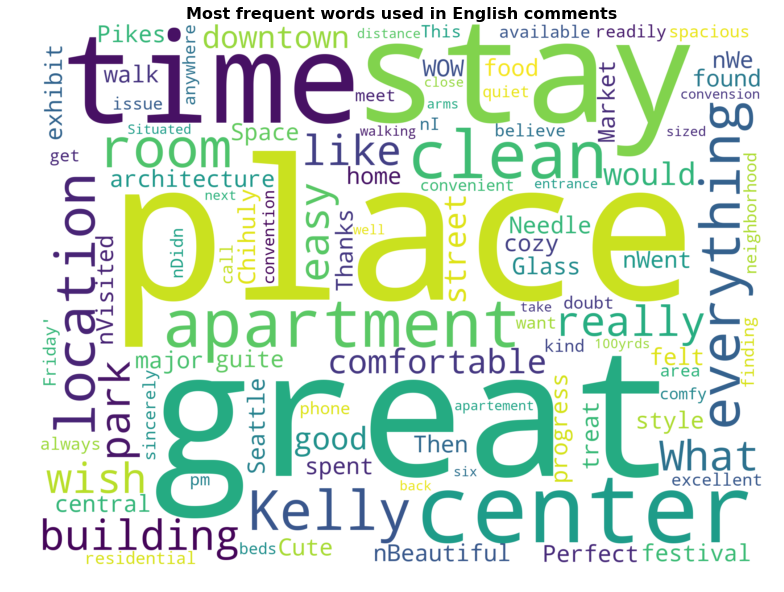

In [35]:
create_wordcloud(df_reviews_en_new, 'comments', 'English comments')

#### 3.2 Feature engineering for sentiment analysis

In this step, we will use VADER - a rule/lexicon-based, open-source sentiment analyzer for sentiment analysis of reviews. This is a pre-built library available in nltk (Natural Language Toolkit) and fully open-sourced under the MIT License. 

VADER processes the text and returns four sentiment metric categories based on internal ratings. The "pos", "neu" and "neg" scores represent proportion of text that fall in each category (all add up to 1). The compound score(or the aggregated score) sums up all the lexicon ratings of each word and is weighted and normalized to a range between -1 (most negative) and +1 (most positive). 

Typical threshold values of compound score are:

positive sentiment: >= 0.05 <br>
neutral sentiment: > -0.05 and < 0.05)<br>
negative sentiment: <= -0.05<br>


In [36]:
# Create a scorer for sentiment analysis
scorer = SIA()

In [37]:
# Create a function to generate sentiment scores reviews text using VADER
def sentiment_scores(reviews):
    """
    Calculate the sentiment score of a text
    Input - text: Text to be analyzed
    Output: Calculated sentiment scores (negative, neutral, positive and compount)
    """
    scores = scorer.polarity_scores(reviews)
    return scores
    

In [38]:
# Print the sentiment scores of an example comment
print("Sentence: '{}'\nSentiment scores: {}"\
      .format(df_reviews_en_new['comments'][0], 
              sentiment_scores(df_reviews_en_new['comments'][0])))

Sentence: 'Cute and cozy place. Perfect location to everything! '
Sentiment scores: {'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'compound': 0.7901}


In [39]:
# Calculate the negative, neutral, positive and compound score
def negative_score(reviews):
    neg = scorer.polarity_scores(reviews)['neg']
    return neg

def neutral_score(reviews):
    neu = scorer.polarity_scores(reviews)['neu']
    return neu

def positive_score(reviews):
    pos = scorer.polarity_scores(reviews)['pos']
    return pos

def compound_score(reviews):
    comp = scorer.polarity_scores(reviews)['compound']
    return comp

In [40]:
# Calculate sentiment score of every single review 
# and generate one new column for each score category

df_reviews_en_clean['neg_sentiment_score'] = df_reviews_en_clean['comments']\
                                                            .apply(negative_score)
df_reviews_en_clean['neu_sentiment_score'] = df_reviews_en_clean['comments']\
                                                            .apply(neutral_score)
df_reviews_en_clean['pos_sentiment_score'] = df_reviews_en_clean['comments']\
                                                            .apply(positive_score)
df_reviews_en_clean['compound_sentiment_score'] = df_reviews_en_clean['comments']\
                                                            .apply(compound_score) # ~ 6min

In [41]:
df_reviews_en_clean.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,neg_sentiment_score,neu_sentiment_score,pos_sentiment_score,compound_sentiment_score
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to everything!,en,0.0,0.462,0.538,0.7901


#### 3.3 Sentiment visualization

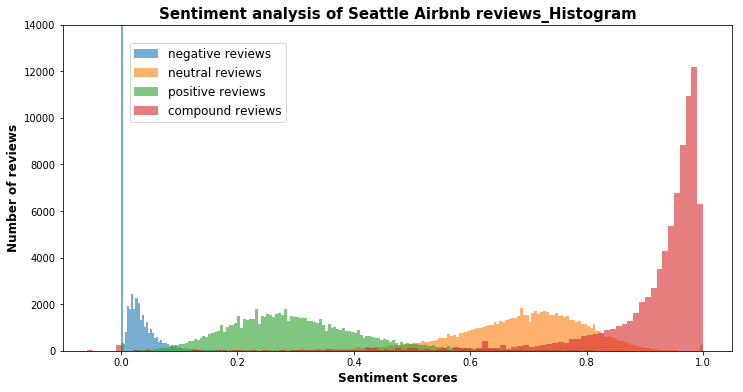

In [42]:
# plot the sentiment scores by category using histogram

plt.figure(figsize = (12, 6))
plt.hist(df_reviews_en_clean['neg_sentiment_score'], bins = 200, 
         alpha = 0.6, label = 'negative reviews')
plt.hist(df_reviews_en_clean['neu_sentiment_score'], bins = 200, 
         alpha = 0.6, label = 'neutral reviews')
plt.hist(df_reviews_en_clean['pos_sentiment_score'], bins = 200, 
         alpha = 0.6, label = 'positive reviews')
plt.hist(df_reviews_en_clean['compound_sentiment_score'], bins = 200, 
         alpha = 0.6, label = 'compound reviews') 

plt.xlim(xmin = - 0.1, xmax = 1.05)
plt.ylim(ymin = 0, ymax = 14000)

plt.xlabel('Sentiment Scores', fontsize = 12, fontweight = 'bold')
plt.ylabel('Number of reviews', fontsize = 12, fontweight = 'bold')
plt.title('Sentiment analysis of Seattle Airbnb reviews_Histogram', 
          fontsize = 15, fontweight = 'bold')

plt.legend(loc = (0.1, 0.7), prop = {'size': 12})
plt.savefig('sentiment_score_distribution_histogram.png')

plt.show()

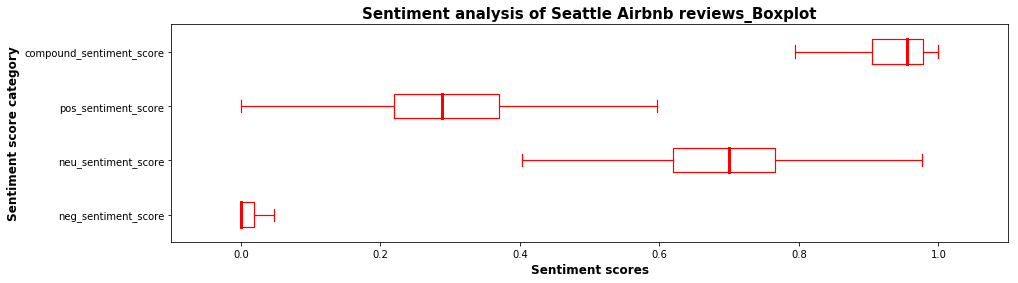

In [68]:
# plot the sentiment scores by category using boxplot

boxplot = df_reviews_en_clean.iloc[:, -4:].plot(kind = 'box', 
                                                color = 'red', vert = False,
                                                boxprops = dict(linewidth = 1.2),
                                                medianprops = dict(linewidth = 3),
                                                whiskerprops = dict(linewidth = 1.2),
                                                capprops = dict(linewidth = 1.2), 
                                                showfliers = False, 
                                                figsize = (15, 4))

plt.xlim(xmin = -0.1, xmax = 1.1)

plt.xlabel('Sentiment scores', fontsize = 12, fontweight = 'bold')
plt.ylabel('Sentiment score category', fontsize = 12, fontweight = 'bold')
plt.title('Sentiment analysis of Seattle Airbnb reviews_Boxplot', 
          fontsize = 15, fontweight = 'bold')

plt.savefig('sentiment_score_distribution_boxplot.png')
plt.show()

In [44]:
# Data distribution of negative sentiment scores
df_reviews_en_clean[df_reviews_en_clean['neg_sentiment_score'] < 0.01]\
                    ['neg_sentiment_score'].value_counts()


0.000    56744
0.009    284  
0.008    211  
0.007    127  
0.006    88   
0.005    46   
0.004    22   
0.003    5    
Name: neg_sentiment_score, dtype: int64

We can see from the histogram and boxplot that there's a HUGE number of zeros in the neg_sentiment_score columns, which is actually a good thing - this means most of the reviews are very unlikely to be negative, therefore the majority of reviews are positive or at least neutral. The compound_sentiment_score distribution is highly left skewed, which also indicates that most reviews are positive.

### 4. Sentiment Prediction using NLP

#### 4.1 Create the dataset for prediction

In [45]:
# Create a sub dataset for building a prediciton model
df_reviews_subset = df_reviews_en_clean[['comments', 'compound_sentiment_score']]
df_reviews_subset.head()

,comments,compound_sentiment_score
0,Cute and cozy place. Perfect location to everything!,0.7901
1,"Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW. Thanks for a great stay.",0.9872
2,"Very spacious apartment, and in a great neighborhood. This is the kind of apartment I wish I had!\r\n\r\nDidn't really get to meet Kelly until I was on my out, but she was always readily available by phone. \r\n\r\nI believe the only ""issue"" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday",0.8718
3,"Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the Metropolitan (probably the coolest grocer you'll ever find). Easy to find and Kelly was warm, welcoming, and really interesting to talk to.",0.8313
4,Kelly was a great host and very accommodating in a great neighborhood. She has some great coffee and while I wasn't around much during my stay the time I spent interacting with her was very pleasant. \r\n\r\nThe apartment is in a great location and very close to the Seattle Center. The neighborhood itself has a lot of good food as well!,0.9783


#### 4.2 Create a `sentiment_category` column to classify sentiment scores

In [46]:
def convert_sentiment_score_to_integer(df):
    """
    Convert the sentiment score into three categories:
    2: positive
    1: neutral
    0: negative
    
    Input - df: dataframe to be processed
    Output - df: a new dataframe with a new column of sentiment_category
    """
    
    for idx, row in df.iterrows():
        #print(row)
        if row['compound_sentiment_score'] >= 0.05:
            df.loc[idx, 'sentiment_category'] = 2 # positive sentiment
        elif row['compound_sentiment_score'] > -0.05 and \
                    row['compound_sentiment_score'] < 0.05:
            df.loc[idx, 'sentiment_category'] = 1 # neutral sentiment
        else:
            df.loc[idx, 'sentiment_category'] = 0 # negative sentiment
    
    return df


In [47]:
# Apply the function to the subset to generate the sentiment category of 2, 1 and 0
df_reviews_subset = df_reviews_subset.copy()
convert_sentiment_score_to_integer(df_reviews_subset)

df_reviews_subset['sentiment_category'] = \
                        df_reviews_subset['sentiment_category'].astype(int)

df_reviews_subset.head()

,comments,compound_sentiment_score,sentiment_category
0,Cute and cozy place. Perfect location to everything!,0.7901,2
1,"Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW. Thanks for a great stay.",0.9872,2
2,"Very spacious apartment, and in a great neighborhood. This is the kind of apartment I wish I had!\r\n\r\nDidn't really get to meet Kelly until I was on my out, but she was always readily available by phone. \r\n\r\nI believe the only ""issue"" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday",0.8718,2
3,"Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the Metropolitan (probably the coolest grocer you'll ever find). Easy to find and Kelly was warm, welcoming, and really interesting to talk to.",0.8313,2
4,Kelly was a great host and very accommodating in a great neighborhood. She has some great coffee and while I wasn't around much during my stay the time I spent interacting with her was very pleasant. \r\n\r\nThe apartment is in a great location and very close to the Seattle Center. The neighborhood itself has a lot of good food as well!,0.9783,2


In [48]:
# Count the number of reviews in each sentiment category
print('positive reviews:', df_reviews_subset['sentiment_category']\
                              [df_reviews_subset['sentiment_category'] == 2].count())
print('neutral reviews:', df_reviews_subset['sentiment_category']\
                              [df_reviews_subset['sentiment_category'] == 1].count())
print('negative reviews:', df_reviews_subset['sentiment_category']\
                              [df_reviews_subset['sentiment_category'] == 0].count())

positive reviews: 82047
neutral reviews: 321
negative reviews: 566


Since this preprocessed dataset is pretty imbalanced with significantly less negative reviews. If we train a model to predict sentiment of reviews, we may not expect high accuracy on negative ones. But at least we can give it a try!

#### 4.3 Collect positive and negative reviews

In [49]:
# Create positive review dataframe
positive_reviews = df_reviews_subset[df_reviews_subset['sentiment_category'] == 2]
positive_reviews.head()

,comments,compound_sentiment_score,sentiment_category
0,Cute and cozy place. Perfect location to everything!,0.7901,2
1,"Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW. Thanks for a great stay.",0.9872,2
2,"Very spacious apartment, and in a great neighborhood. This is the kind of apartment I wish I had!\r\n\r\nDidn't really get to meet Kelly until I was on my out, but she was always readily available by phone. \r\n\r\nI believe the only ""issue"" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday",0.8718,2
3,"Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the Metropolitan (probably the coolest grocer you'll ever find). Easy to find and Kelly was warm, welcoming, and really interesting to talk to.",0.8313,2
4,Kelly was a great host and very accommodating in a great neighborhood. She has some great coffee and while I wasn't around much during my stay the time I spent interacting with her was very pleasant. \r\n\r\nThe apartment is in a great location and very close to the Seattle Center. The neighborhood itself has a lot of good food as well!,0.9783,2


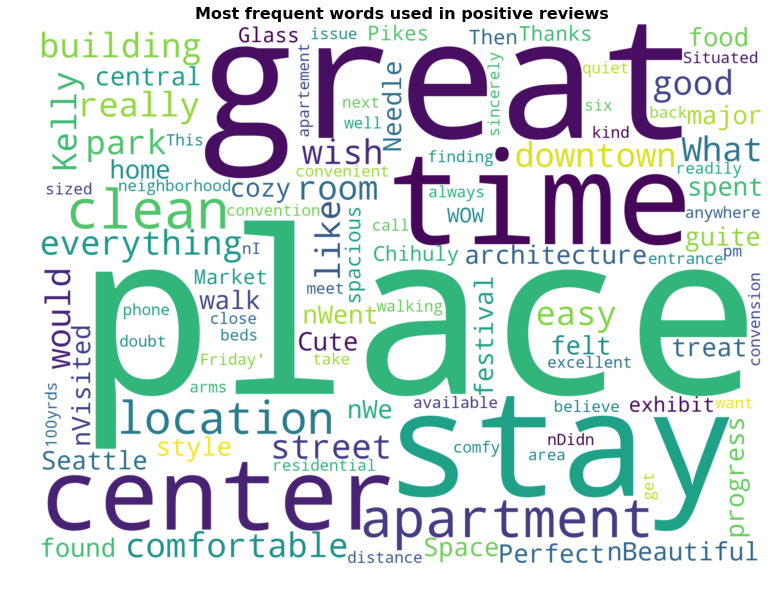

In [50]:
# Display the top 100 most frequently used words in positive comments
create_wordcloud(positive_reviews, 'comments', 'positive reviews')

From this word cloud, we can see that the most frequently used words in positive reviews are "place", "stay", "time", "apartment", etc.

Except for these more neutral words, we also see some positive words like "great", "comfortable", "clean", "perfect", "cozy", "wow", "excellent", "cute", "easy", "good",etc. It's also interesting to see some Seattle-specific words like "Chihuly", "Needle", "Pikes".

And there're also some words that refer to location and amenities, like "location", "distance", "walk", "park", "center", "downtown", "food", "exhibit", etc. Looks like the visitors are pretty happy with the location and nearby facilities.

In [51]:
# Create negative review dataframe
negative_reviews = df_reviews_subset[df_reviews_subset['sentiment_category'] == 0]
negative_reviews.head()

,comments,compound_sentiment_score,sentiment_category
189,"Cozy and very private space! Close to beach, shopping, main street with restaurants. The only thing little uncomfortable ( and if the weather is cold) is that the bathroom/shower is outside the room, one has to go out through the patio to the main house.",-0.3816,0
729,"The apartment was as advertised, 4 blocks to Capitol Hill restaurants. No soap or shampoo conditioner so I went out to buy some at the nearby convenience store. Nice touch to have a bottle of wine waiting for us!",-0.1511,0
1083,"Our stay was great. There are plenty of restaurants within walking distance and the kitchen at the apartment is fabulous. We were in town for a conference at UW and walked there every day. Christine was very responsive throughout our stay and made check-in and out easy. The shower is a bit crazy (you have to sit down), but once you get used to it, it's no problem.",-0.1163,0
1253,"Location is directly below major freeway #5. No air conditioning, and suite was 86 degrees when we arrived. Opened the window to cool it down but had to shout at each other with the window open due to freeway noise. There is a tower fan provided. One towel and one facecloth was provided for my wife and I. The shower curtain is extremely dirty at the bottom from. There appears to be a dog that resides in the residence as there was hair found on night stand and dog food present. I should have inquired about this more carefully with my (website hidden) is being acquired off of Amazon, i think, and channel reception was so very poor we could not watch any. This was our first time having experienced coming into someone's home where they typically live every day and simply moved out for the night to allow us to stay there. We will be more selective in the future.",-0.4779,0
1267,"The host and his roommates were very prompt in helpful with email communications before and during my stay. The location is very good, close to amenities and transit. Neighborhood is urban and full of construction and diversity. House and room description are accurate, though this is an older home in decent but not excellent repair. When I was there the shower water supply was inadequate to wash my hair, but host is tring to remedy situation. Shared bathroom wasn't sparkly clean but adequate (C-).",-0.4321,0


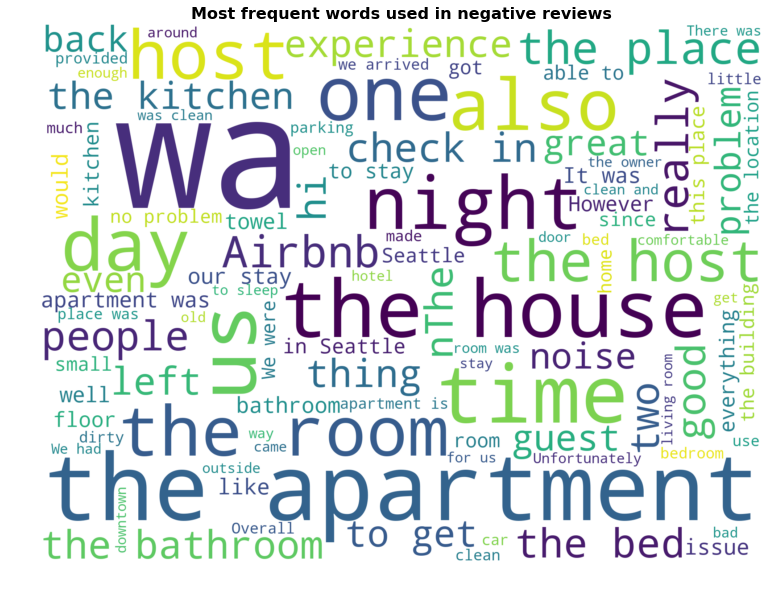

In [52]:
# Display the top 100 most frequently used words in negative comments
create_wordcloud(negative_reviews, 'comments', 'negative reviews')

Since we don't have many negative reviews, it's a little bit hard to find negative words in these reviews. Most of these words are neutral or nouns that do not give much information about the sentiment. But we still can find some negative words like "bad", "old", "small", "dirty", "unfortunately", "noise", "problem", "little", etc.

There're also plenty of words that refer to location, services and amenities, like "location", "downtown", "parking",  "bathroom", "kitchen", "towel", "shower", "check in", etc.

Again, since the dataset is pretty imbalanced, there're also some positive words that are mislabeled or embedded in a neutral-negative review (e.g., "comfortable", "great", "good", etc.)

#### 4.4 Create training and test datasets

In [53]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [54]:
# Split training data and labels
X = df_reviews_subset['comments']
y = df_reviews_subset[['sentiment_category']]

In [55]:
# Convert y labels into three categories
y = to_categorical(np.asarray(y)) # neg, neu, pos

In [56]:
print(len(X), len(y))

82934 82934


In [57]:
# Split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [58]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((66347,), (66347, 3), (16587,), (16587, 3))

#### 4.5 Text preprocessing

In [59]:
# Tokenize the words and sequence the sentences

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

vocab_size = len(word_index) + 1
max_length = 100 # Many negative reviews are long 
embedding_dim = 16
trunc_type = 'post'
pad_type = 'post'


In [60]:
# Pad the sequences with same length

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen = max_length, 
                                truncating = trunc_type, padding = pad_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen = max_length)

training_labels = np.array(y_train)
test_labels = np.array(y_test)

In [61]:
# train the model using CNN

from keras.models import Sequential
from keras.layers import Dense

num_epochs = 30
batch_size = 32

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.Conv1D(16, 5, activation = 'relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(32, activation ='relu'),
    keras.layers.Dense(3, activation = 'softmax')
])


In [62]:
# Compile the cnn model

learning_rate = 0.0001 # choose a small learning rate

model.compile(loss = 'categorical_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate), 
              metrics = ['accuracy'])


In [63]:
# Set early stoppping to stop training when performance starts to decrease
early_stopping = keras.callbacks.EarlyStopping(patience = 5)

history = model.fit(training_padded, training_labels, 
                    validation_data = (test_padded, test_labels),
                    epochs = num_epochs, batch_size = batch_size,
                    callbacks = [early_stopping])


Train on 66347 samples, validate on 16587 samples
Epoch 1/30
66347/66347 [==============================] - 18s 270us/step - loss: 0.2130 - accuracy: 0.9804 - val_loss: 0.0561 - val_accuracy: 0.9904
Epoch 2/30
66347/66347 [==============================] - 17s 262us/step - loss: 0.0598 - accuracy: 0.9890 - val_loss: 0.0527 - val_accuracy: 0.9904
Epoch 3/30
66347/66347 [==============================] - 17s 262us/step - loss: 0.0545 - accuracy: 0.9890 - val_loss: 0.0480 - val_accuracy: 0.9904
Epoch 4/30
66347/66347 [==============================] - 17s 264us/step - loss: 0.0484 - accuracy: 0.9890 - val_loss: 0.0447 - val_accuracy: 0.9904
Epoch 5/30
66347/66347 [==============================] - 17s 262us/step - loss: 0.0426 - accuracy: 0.9890 - val_loss: 0.0416 - val_accuracy: 0.9904
Epoch 6/30
66347/66347 [==============================] - 17s 262us/step - loss: 0.0374 - accuracy: 0.9893 - val_loss: 0.0397 - val_accuracy: 0.9904
Epoch 7/30
66347/66347 [==============================]

In [64]:
# Plot the accuracy and loss data

def plot_graphs(history, parameter):
    """
    Plot the prediction parameter against epochs
    
    Input - history: the sentiment prediction model
            parameter: the parameter to be plotted
    Output - a parameter - epoch graph
    """
    
    plt.plot(history.history[parameter])
    plt.plot(history.history['val_' + parameter])
    plt.xlabel('Epochs')
    plt.ylabel(parameter)
    plt.legend(loc = 'best')
    plt.legend(['training_' + parameter, 'val_' + parameter])
    
    plt.savefig('CNN performance curve.png')
    plt.show()

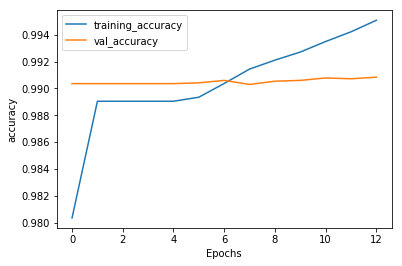

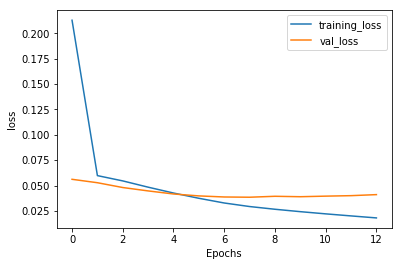

In [65]:
# Plot accuracy and loss against epochs
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [66]:
# Write a function to predict the sentiment of new reviews

def predict_review(model, text):
    """
    Predict the sentiment of a give text
    Input - model: the sentiment prediction model
            text: reviews to be analyzed
    Output - the predicted sentiment scores of the given text
    """
    
    # Create the sequences
    sequences = tokenizer.texts_to_sequences(text)
    text_padded = pad_sequences(sequences, padding = 'post', maxlen = max_length)
    sentiment_categories = model.predict(text_padded)

    for score in range(len(text_padded)):
        print(text[score])
        print('Negative Score: {:.3f}, Neutral Score: {:.3f}, Positive Score: {:.3f}'\
              .format(round(sentiment_categories[score][0], 2), 
                      round(sentiment_categories[score][1], 2),
                      round(sentiment_categories[score][2], 2)))
        print('\n')

In [67]:
# Create some new reviews for test

review1 = 'This is a nice place. Definitely stay here when you visit Seattle!'
review2 = "There is no better place than Kate's house!"
review3 = 'The overall experience is good except that \
the dryer in the bathroom is not working. '
review4 = "I don't know what to complain but everything is perfect for me. \
Thank you Kevin!"
review5 = "The location is not as close to the Space Needle as described. \
Very disappointing!!!"

new_reviews = [review1, review2, review3, review4, review5]

# Predict the sentiment of new reviews
predict_review(model, new_reviews)

This is a nice place. Definitely stay here when you visit Seattle!
Negative Score: 0.000, Neutral Score: 0.000, Positive Score: 1.000


There is no better place than Kate's house!
Negative Score: 0.080, Neutral Score: 0.060, Positive Score: 0.870


The overall experience is good except that the dryer in the bathroom is not working. 
Negative Score: 0.240, Neutral Score: 0.030, Positive Score: 0.730


I don't know what to complain but everything is perfect for me. Thank you Kevin!
Negative Score: 0.000, Neutral Score: 0.000, Positive Score: 1.000


The location is not as close to the Space Needle as described. Very disappointing!!!
Negative Score: 0.310, Neutral Score: 0.570, Positive Score: 0.120




## Conclusions

In this notebook, we took a closer look at the visitor reviews and tried to analyze the text sentiment. We were able to:

1. Identify some positive and negative words that were frequently used by the visitors (with many common words used in both reviews), and 

2. Build a simple convolutional neural network model to predict some new reviews, even through we only have a very imbalanced dataset. 

There're still many things that can be improved in this work and we may try it another time using a more balanced dataset.

## References
1. https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin
2. https://datatofish.com/integers-to-strings-dataframe/
3. https://www.kaggle.com/brittabettendorf/nlp-on-airbnb-data
4. https://stackoverflow.com/questions/53878141/how-to-show-wordcloud-from-a-dataframe-in-python
5. https://www.nltk.org/api/nltk.sentiment.html
6. Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
7. https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
8. https://medium.com/@Intellica.AI/vader-ibm-watson-or-textblob-which-is-better-for-unsupervised-sentiment-analysis-db4143a39445
9. https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
10. https://github.com/cjhutto/vaderSentiment#about-the-scoring
11. https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart-with-matplotlib
12. https://wellsr.com/python/python-create-pandas-boxplots-with-dataframes/
13. https://stackoverflow.com/questions/49392972/error-when-checking-target-expected-dense-3-to-have-shape-3-but-got-array-wi
14. https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187
15. https://github.com/keras-team/keras/issues/12940